# Process GPAHE data

In [1]:
import pandas as pd
import spacy
from IPython.display import Image
from wikidata.client import Client

In [2]:
SPACY_FIELD_NAMES = "DATE EVENT FAC GPE LANGUAGE LAW LOC MONEY NOMINAL NORP ORDINAL ORG PERCENT PERSON PRODUCT QUANTITY TIME WORK_OF_ART".split()

nlp = spacy.load('en_core_web_sm') 

In [3]:
DATA_FILE = "../../data/scraped_symbol_dict.json"
data_df = pd.read_json(DATA_FILE).T

## 1. Identify and count entities in description

In [4]:
def get_entities(nlp_analysis):
    entities = {}
    for entity in nlp_analysis.ents:
        if entity.label_ not in entities:
            entities[entity.label_] = []
        entities[entity.label_].append(entity.text)
    return entities

In [5]:
def add_nlp_analysis(data_df, nlp):
    entity_data = []
    for index, row in data_df.iterrows():
        nlp_analysis = nlp(row["Description"]) 
        entities = get_entities(nlp_analysis)
        entity_data.append(entities)
    data_df["entities"] = entity_data
    return data_df

In [6]:
data_nlp_df = add_nlp_analysis(data_df, nlp)

In [7]:
def count(data_nlp_df, field_name, n=10):
    values = {}
    for field_values in data_nlp_df["entities"]:
        if field_name in field_values:
            for field_value in field_values[field_name]:
                if field_value in values:
                    values[field_value] += 1
                else:
                    values[field_value] = 1
    print(f"{field_name} ({sum(values.values())}):", [[key, value] for key, value in sorted(values.items(), key=lambda item: item[1], reverse=True)][:n])

In [8]:
for field_name in SPACY_FIELD_NAMES:
    count(data_nlp_df, field_name)

DATE (897): [['December 2020', 89], ['2023', 49], ['2016', 45], ['2020', 42], ['2017', 27], ['January 6th', 25], ['more than 20 years', 24], ['Today', 18], ['today', 16], ['2019', 15]]
EVENT (62): [['Holocaust', 10], ['World War II', 10], ['WWII', 8], ['the Spanish Civil War', 2], ['the New Resistance', 2], ["the Provence-Alpes-Côte d'Azur", 1], ['post-World War II', 1], ['Civil War', 1], ['the "Carecas do', 1], ['Indian War', 1]]
FAC (102): [['Capitol', 51], ['Svarogov Square', 3], ['the Centre-Val de Loire', 2], ['Alamo', 2], ['the Third Reich', 2], ['Heretic Camp', 2], ['Родина', 2], ['mosques', 2], ["James the Great's", 1], ['Breton', 1]]
GPE (1308): [['France', 130], ['the United States', 64], ['Ukraine', 47], ['Germany', 41], ['U.S.', 37], ['Russia', 36], ['Italy', 29], ['Brazil', 28], ['Canada', 26], ['Portugal', 25]]
LANGUAGE (15): [['English', 9], ['Spanish', 2], ['French', 2], ['Hebrew', 1], ['Russian', 1]]
LAW (12): [['a "Elhaz Rune', 2], ['the Torcidas Anti-Antifascistas', 

In [9]:
count(data_nlp_df, "organizations")

organizations (0): []


In [10]:
count(data_nlp_df, "locations")

locations (0): []


In [11]:
count(data_nlp_df, "events")

events (0): []


In [12]:
count(data_nlp_df, "dates")

dates (0): []


## 2. Link to wikidata (fails)

In [ ]:
client = Client()  # doctest: +SKIP
entity = client.get('Q20145', load=True)

In [ ]:
entity

In [ ]:
import pywikibot
from pywikibot import pagegenerators, WikidataBot

In [ ]:
sparql = "SELECT ?item WHERE { ?item rdfs:label 'Google'@en }"
entities = pagegenerators.WikidataSPARQLPageGenerator(sparql)
entities = list(entities)

## 3. download logo's manually (lot of work)

In [13]:
from bs4 import BeautifulSoup
import urllib.request
import webbrowser

In [14]:
base_url = "https://symbols.globalextremism.org/details?recordId="

In [15]:
COUNTER_MINIMUM = 50
counter = 0
for id in data_df.index:
    counter += 1
    if counter > COUNTER_MINIMUM:
       webbrowser.open(base_url + id, new=2)
       print(counter)
       input()

51


52


53


54


55


56


57


58


59


60


KeyboardInterrupt: Interrupted by user

## 4. Cluster hate symbols

Use https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html as example

In [4]:
import matplotlib.pyplot as plt
import regex
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [80]:
def get_text_data(data_df):
    texts = []
    for _, row in data_df.iterrows():
        description = row["Description"]
        ideology = "# Ideology is " + regex.sub(",", " # Ideology is", row["Ideology"])
        location = "# Location is " + regex.sub(",", " # Location is", row["Location"])
        texts.append(" ".join([description, ideology, location]))
    return texts

In [115]:
def vectorize_text_data(texts, nbr_of_dimensions=5):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(texts)
    vectorized_data = TruncatedSVD(n_components=nbr_of_dimensions, n_iter=5, random_state=42)
    vectorized_data.fit(X.T)
    return vectorized_data

Interesting words for clustering:
* chapter
* club/klub
* group
* organization
* party
* proud (boys)

In [136]:
def visualize(texts, vectorized_data, dimension_1=0, dimension_2=1):
    try:
        x = vectorized_data.components_[dimension_1]
        y = vectorized_data.components_[dimension_2]
    except:
        raise ValueError(f"invalid pair of dimensions ({dimension_1}, {dimension_2})")
    split_data = split_data_by_content(x, y, texts)
    plt.figure(figsize=(24, 12))
    for color in sorted(split_data.keys(), reverse=True):
        plt.scatter(split_data[color][0], split_data[color][1], c=color, label=color, alpha=0.5)
    for i in range(0, len(x)):
        plt.annotate(str(i), (x[i], y[i]))
    plt.legend(labels=[ label for color, label in sorted(labels.items(), reverse=True) ] )
    plt.title(f"{len(x)} hate symbols clustered by description, ideology and location")
    plt.show()

In [168]:
red_token = "proud boys"
orange_token = "chapter"
yellow_token = "[kc]lub"
green_token = "group"
other_color = "blue"
labels = { "yellow": yellow_token, "red": red_token, "orange": orange_token, "green": green_token, other_color: "other" }

def split_data_by_content(x, y, texts):
    split_data = { other_color: [[], []], "green": [[], []], "orange": [[], []], "red": [[], []], "yellow": [[], []] }
    for i in range(0, len(x)):
        if regex.search(red_token, texts[i], regex.IGNORECASE):
            split_data["red"][0].append(x[i])
            split_data["red"][1].append(y[i])
        elif regex.search(orange_token, texts[i], regex.IGNORECASE):
            split_data["orange"][0].append(x[i])
            split_data["orange"][1].append(y[i])
        elif regex.search(yellow_token, texts[i], regex.IGNORECASE):
            split_data["yellow"][0].append(x[i])
            split_data["yellow"][1].append(y[i])
        elif regex.search(green_token, texts[i], regex.IGNORECASE):
            split_data["green"][0].append(x[i])
            split_data["green"][1].append(y[i])
        else:
            split_data[other_color][0].append(x[i])
            split_data[other_color][1].append(y[i])
    return split_data

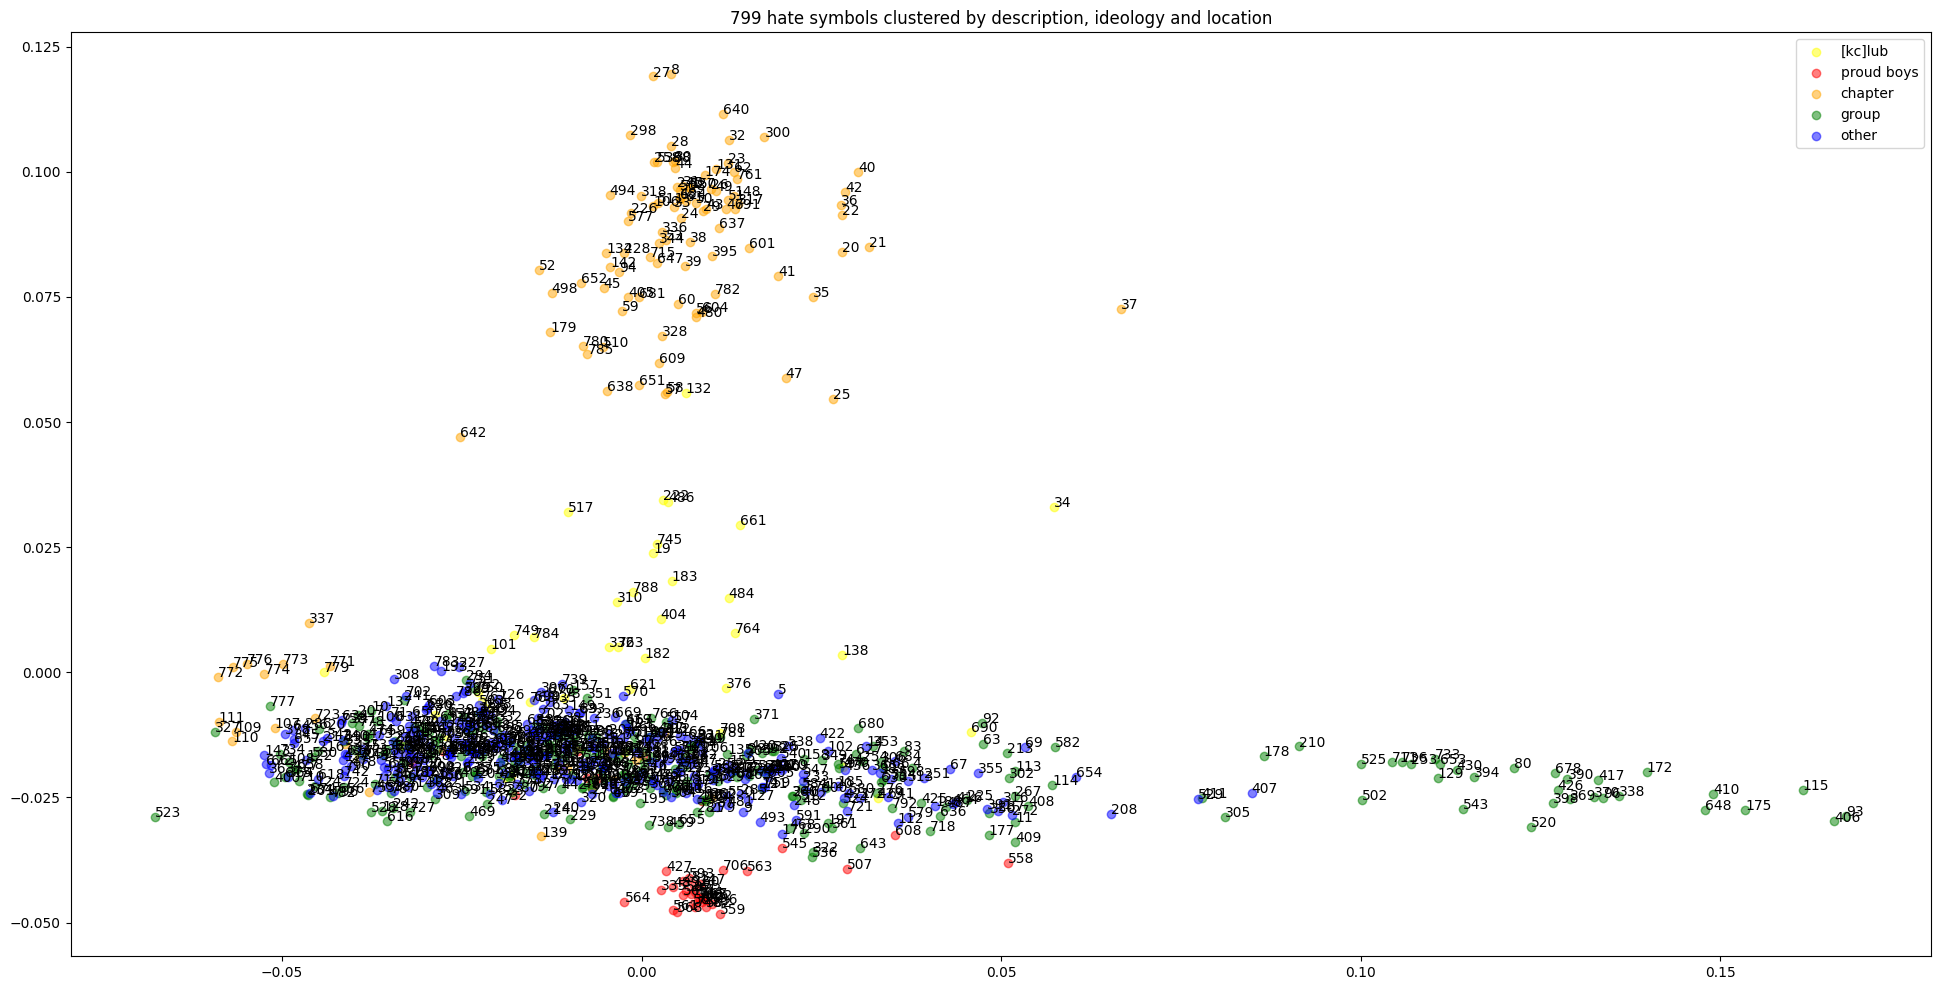

In [169]:
texts = get_text_data(data_df)
vectorized_data = vectorize_text_data(texts)
visualize(texts, vectorized_data, dimension_1=3, dimension_2=1)

In [163]:
data_df.iloc[523]["Description"]

'Traditionally part of the Runic alphabet, the Othala/Odal (also "Odin") was used by some Waffen SS divisions in Nazi Germany. It was later further co-opted by white supremacists as a stand-in for the swastika in many instances. The National Socialist Movement uses it as part of their flag, and many skinheads use the symbol as well. The symbol has also been seen on vehicles used by the Russian Wagner Group.'

##  Make a knowledge base

* https://medium.com/nlplanet/building-a-knowledge-base-from-texts-a-full-practical-example-8dbbffb912fa
* https://neo4j.com/blog/text-to-knowledge-graph-information-extraction-pipeline/
* https://neo4j.com/developer-blog/construct-knowledge-graphs-unstructured-text/
* https://towardsdatascience.com/how-to-convert-any-text-into-a-graph-of-concepts-110844f22a1a